# Reto Coppel


## Importación de librerías

In [433]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox, expon, weibull_min, gamma, lognorm, pareto, probplot, kstest
from distfit import distfit

## Carga de datos

In [48]:
retail = pd.read_csv("../dataset.csv")

Cambiemos los nombres de los atributos a un mismo formato.

In [49]:
retail.columns = retail.columns.str.capitalize()

Trabajaremos solo con los datos de retail debido a los recursos computacionales limitados y a que es el segmento más problemático.

In [50]:
retail = retail[retail['Segmento'] == "retail"]

## Inspección

In [51]:
retail.head()

,Unnamed: 0,Fecha,Segmento,Hora_llegada,Hora_llamado,Hora_salida,Caja,Tienda,Status,Estado
0,821243,2023-01-01,retail,0.503465,0.503477,0.503581,caja_a,Tienda_A,Atendido,Ciudad de México
1,821244,2023-01-01,retail,0.503581,0.503616,0.511174,caja_a,Tienda_A,Atendido,Ciudad de México
2,821245,2023-01-01,retail,0.503789,0.503801,0.505120,caja_b,Tienda_A,Atendido,Ciudad de México
3,821246,2023-01-01,retail,0.503847,0.505132,0.509333,caja_b,Tienda_A,Atendido,Ciudad de México
4,821247,2023-01-01,retail,0.503894,0.508072,0.509981,caja_c,Tienda_A,Atendido,Ciudad de México


In [52]:
retail.shape

(9987098, 10)

### Tipos de datos

In [53]:
retail.dtypes

Unnamed: 0        int64
Fecha            object
Segmento         object
Hora_llegada    float64
Hora_llamado    float64
Hora_salida     float64
Caja             object
Tienda           object
Status           object
Estado           object
dtype: object

El tipo de dato de cada atributo corresponde a la naturaleza del atributo excepto *Fecha*.

### Valores nulos

In [54]:
retail.isnull().sum()

Unnamed: 0      0
Fecha           0
Segmento        0
Hora_llegada    0
Hora_llamado    0
Hora_salida     0
Caja            0
Tienda          0
Status          0
Estado          0
dtype: int64

No hay valores nulos.

### Valores únicos

In [32]:
def imprimir_datos(datos):
    for dato in datos:
        print(dato)

Revisemos que los datos se hayan filtrado correctamente.

In [33]:
imprimir_datos(retail['Segmento'].unique())


retail


In [34]:
imprimir_datos(retail['Caja'].unique())

caja_a
caja_b
caja_c
caja_d
caja_e
caja_f
caja_j
caja_h
caja_i
caja_k
caja_l
caja_m
caja_n
ventanilla_b
caja_o
caja_p
caja_q
ventanilla_d
p_b
ventanilla_c
p_a
p_f
p_h
ventanilla_a
p_m
p_e
p_g
ventanilla_f
p_d
p_c
p_k
p_j
p_i
ventanilla_e
ventanilla_g
p_n
caja_r
caja_s
caja_t
caja_u
caja_v
Caja_a
Caja_b
Caja_c
Caja_d
Caja_e
p_t
p_u
Caja_f
p_v
ventanilla_m
ventanilla_k
ventanilla_o
ventanilla_l
ventanilla_p
p_o
p_q
p_s
ventanilla_j
ventanilla_i
p_p
ventanilla_n
ventanilla_h
ventanilla_s
P_b
ventanilla_r
p_r
p_y
caja_x
p_z
P_c
P_a
p_l
a_a


Se tienen 74 cajas distintas que se dividen en tres tipos: caja, ventanilla, p. Hay errores de etiquetado.

In [35]:
imprimir_datos(retail['Tienda'].unique())

Tienda_A
Tienda_B
Tienda_C
Tienda_D
Tienda_E
Tienda_F
Tienda_G
Tienda_H
Tienda_I
Tienda_J
Tienda_K
Tienda_L
Tienda_M
Tienda_N
Tienda_O
Tienda_P
Tienda_Q
Tienda_R
Tienda_S
Tienda_T
Tienda_U
Tienda_X
Tienda_Y
Tienda_Z
Tienda_V
Tienda_AB
Tienda_AC
Tienda_AE
Tienda_AF
Tienda_AG
Tienda_AH
Tienda_AI
Tienda_AJ
Tienda_AK
Tienda_AA
Tienda_AL
Tienda_AM
Tienda_AN
Tienda_AO
Tienda_AP
Tienda_AQ
Tienda_AX
Tienda_AD
Tienda_AY
Tienda_AZ
Tienda_BA
Tienda_BB
Tienda_BC
Tienda_BD
Tienda_BE


Se tienen 50 tiendas distintas.

In [36]:
imprimir_datos(retail['Status'].unique())

Atendido
Ausente


In [37]:
imprimir_datos(retail['Estado'].unique())

Ciudad de México
Quintana Roo
Sonora
Sinaloa
Veracruz de Ignacio de la Llave
Chiapas
Puebla
Tabasco
Durango
Yucatán
Guanajuato
Chihuahua
Zacatecas
México
Oaxaca
Morelos
Nuevo León
Querétaro
Michoacán de Ocampo
Guerrero
Baja California
Baja California Sur
Coahuila de Zaragoza


Se incluyen solo 23 estados de la república.

Comentario: hay errores de etiquetado en el atributo *Caja*.

## Limpieza de datos

### Errores de tipo de dato

In [55]:
retail['Fecha'] = pd.to_datetime(retail['Fecha'])

### Errores de etiquetado

Corrijamos errores de etiquetado, en este caso, cambiemos todos los valores del atributo *Caja* a minusculas para que no haya valores repetidos que se identifiquen como distintos por el uso de mayusculas.

In [57]:
retail['retail'] = retail['Caja'].str.lower()

### Ruido

Eliminemos las observaciones donde la hora de llegada es mayor que la hora de llamado o salida y las observaciones donde su hora de llamado es mayor al horario de salida

In [58]:
retail = retail[(retail['Hora_llegada'] < retail['Hora_llamado']) &
        (retail['Hora_llegada'] < retail['Hora_salida']) &
        (retail['Hora_llamado'] < retail['Hora_salida'])]
retail.shape[0]

9734454

Se eliminaron 250,000 observaciones, aproximadamente.

## Creación de nuevas columnas

Separemos el atributo compuesto *Fecha* en tres atributos: *Dia*, *Mes* y *Anio*.

In [59]:

retail['Anio'] = retail['Fecha'].dt.year  # Extraer el año
retail['Mes'] = retail['Fecha'].dt.month  # Extraer el mes
retail['Dia'] = retail['Fecha'].dt.day


In [61]:
imprimir_datos(retail['Anio'].unique())

2023
2024


In [63]:
imprimir_datos(retail['Mes'].unique())

1
2
3
4
5
6
7
8
9
10
11
12


In [64]:
imprimir_datos(retail['Dia'].unique())

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [65]:
retail['Dia_semana'] = retail['Fecha'].dt.dayofweek

In [66]:
imprimir_datos(retail['Dia_semana'].unique())

6
0
1
2
3
4
5


Creemos una nueva columna que sea la diferencia de los atributos *Hora_llamado* y *Hora_llegada* para su posterior análisis.

In [85]:
retail['Tiempo_espera'] = retail['Hora_llamado'] - retail['Hora_llegada']

In [86]:
retail.head()

,Unnamed: 0,Fecha,Segmento,Hora_llegada,Hora_llamado,Hora_salida,Caja,Tienda,Status,Estado,retail,Anio,Mes,Dia,Dia_semana,Tiempo_espera
0,821243,2023-01-01,retail,0.503465,0.503477,0.503581,caja_a,Tienda_A,Atendido,Ciudad de México,caja_a,2023,1,1,6,0.000012
1,821244,2023-01-01,retail,0.503581,0.503616,0.511174,caja_a,Tienda_A,Atendido,Ciudad de México,caja_a,2023,1,1,6,0.000035
2,821245,2023-01-01,retail,0.503789,0.503801,0.505120,caja_b,Tienda_A,Atendido,Ciudad de México,caja_b,2023,1,1,6,0.000012
3,821246,2023-01-01,retail,0.503847,0.505132,0.509333,caja_b,Tienda_A,Atendido,Ciudad de México,caja_b,2023,1,1,6,0.001285
4,821247,2023-01-01,retail,0.503894,0.508072,0.509981,caja_c,Tienda_A,Atendido,Ciudad de México,caja_c,2023,1,1,6,0.004178


## Análisis exploratorio de datos

Hagamos un análisis exploratorio por tienda.

In [87]:
retail_por_tienda = dict()
count = 0
for tienda in retail['Tienda'].unique():
    retail_por_tienda[tienda] = retail[retail['Tienda'] == tienda]

Dejamos de lado el atributo *Estado*, ya que no sería necesario si analizaremos los datos por tienda.

In [178]:
def EDA(retail_por_tienda):
    for tienda, conjunto_datos in retail_por_tienda.items():
        print(tienda)
        print("Tiempos de espera")
        print(conjunto_datos['Tiempo_espera'].describe())
        plt.hist(conjunto_datos.Tiempo_espera, bins=20)
        plt.show()
        print("Tiempos de espera por status")
        atendido = conjunto_datos.loc[conjunto_datos.Status == "Atendido", "Tiempo_espera"]
        ausente = conjunto_datos.loc[conjunto_datos.Status == "Ausente", "Tiempo_espera"]
        print(atendido.describe())
        print(ausente.describe())
        plt.hist(atendido, bins=50, density=True)
        plt.hist(ausente, bins=50, density=True, alpha=0.75)
        plt.show()
        print("---------------------------------------")


Tienda_A
Tiempos de espera
count    275357.000000
mean          0.002768
std           0.004437
min           0.000012
25%           0.000463
50%           0.001655
75%           0.003530
max           0.330394
Name: Tiempo_espera, dtype: float64


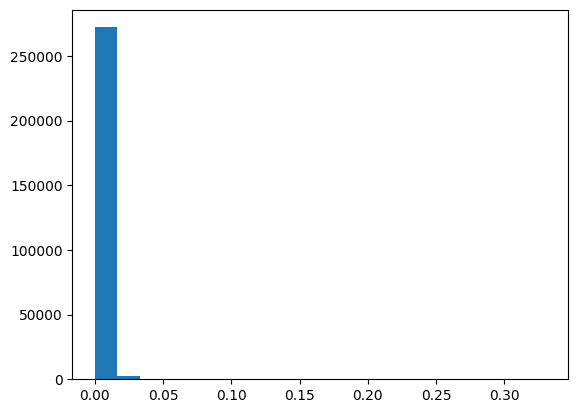

Tiempos de espera por status
count    264454.000000
mean          0.002665
std           0.003948
min           0.000012
25%           0.000440
50%           0.001609
75%           0.003438
max           0.154525
Name: Tiempo_espera, dtype: float64
count    10903.000000
mean         0.005261
std          0.010620
min          0.000012
25%          0.001204
50%          0.002789
75%          0.005694
max          0.330394
Name: Tiempo_espera, dtype: float64


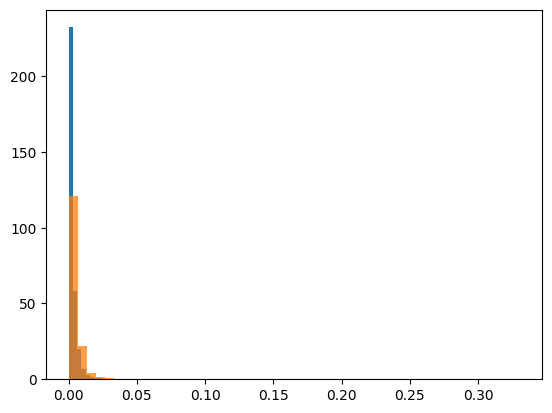

---------------------------------------
Tienda_B
Tiempos de espera
count    222114.000000
mean          0.001381
std           0.003299
min           0.000012
25%           0.000046
50%           0.000532
75%           0.001690
max           0.237060
Name: Tiempo_espera, dtype: float64


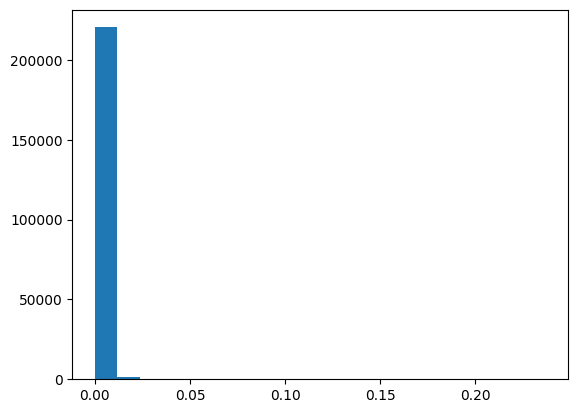

Tiempos de espera por status
count    218686.000000
mean          0.001346
std           0.003102
min           0.000012
25%           0.000046
50%           0.000521
75%           0.001667
max           0.237060
Name: Tiempo_espera, dtype: float64
count    3428.000000
mean        0.003626
std         0.009295
min         0.000012
25%         0.000440
50%         0.001447
75%         0.003623
max         0.212755
Name: Tiempo_espera, dtype: float64


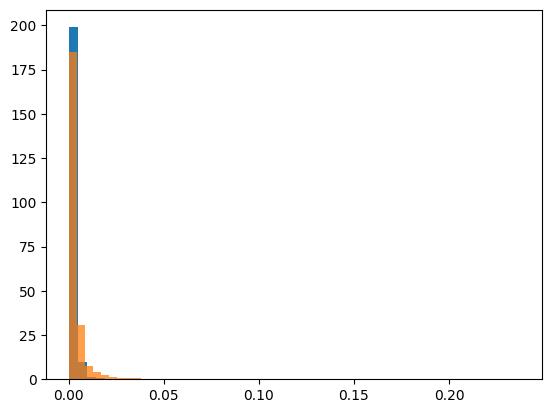

---------------------------------------
Tienda_C
Tiempos de espera
count    84107.000000
mean         0.002873
std          0.012436
min          0.000012
25%          0.000093
50%          0.001019
75%          0.002731
max          0.355556
Name: Tiempo_espera, dtype: float64


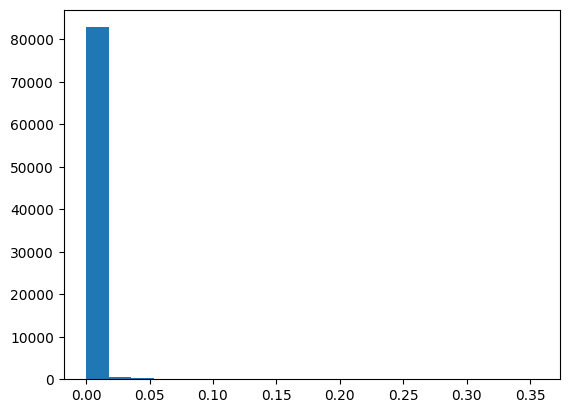

Tiempos de espera por status
count    69402.000000
mean         0.002762
std          0.013332
min          0.000012
25%          0.000058
50%          0.000880
75%          0.002512
max          0.355556
Name: Tiempo_espera, dtype: float64
count    14705.000000
mean         0.003394
std          0.006729
min          0.000012
25%          0.000440
50%          0.001782
75%          0.003889
max          0.140660
Name: Tiempo_espera, dtype: float64


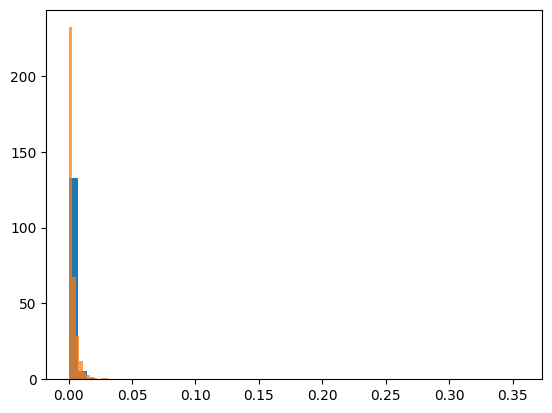

---------------------------------------
Tienda_D
Tiempos de espera
count    131898.000000
mean          0.001552
std           0.004854
min           0.000012
25%           0.000046
50%           0.000451
75%           0.001771
max           0.225208
Name: Tiempo_espera, dtype: float64


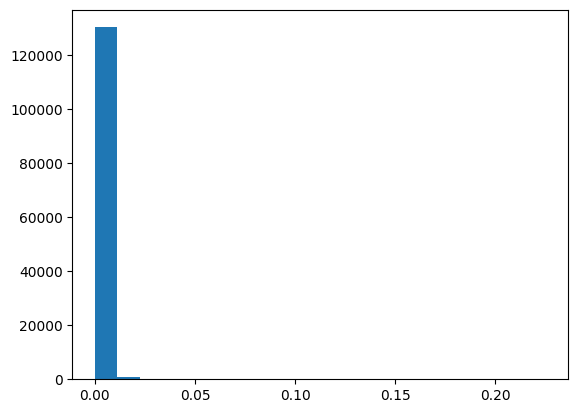

Tiempos de espera por status
count    127924.000000
mean          0.001463
std           0.004535
min           0.000012
25%           0.000046
50%           0.000428
75%           0.001725
max           0.180590
Name: Tiempo_espera, dtype: float64
count    3974.000000
mean        0.004406
std         0.010571
min         0.000012
25%         0.000162
50%         0.001354
75%         0.003877
max         0.225208
Name: Tiempo_espera, dtype: float64


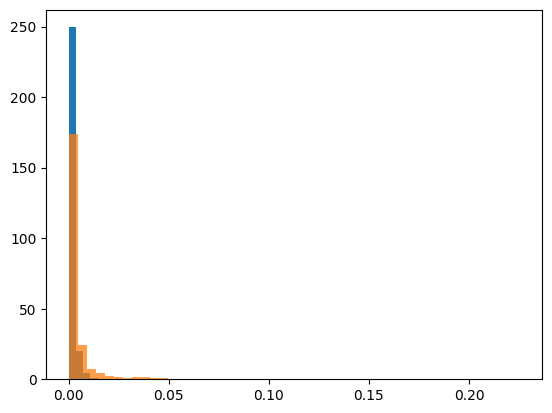

---------------------------------------


In [179]:
EDA(retail_por_tienda)

## Prueba hipótesis

Antes que nada, a pesar de que parezca obvio, sería buena práctica analizar si realmente existe una diferencia entre los tiempos de espera de clientes que fueron atendidos con los que se fueron antes de ser atendidos. Para esto usaremos prueba de permutación para diferencia de medianas.

H0: mediana2 - mediana1 = 0 \
H1: mediana2 - mediana1 != 0

In [146]:
valores_p = []
for tienda, conjunto_datos in retail_por_tienda.items():
    B = 100
    obs = (conjunto_datos[conjunto_datos['Status'] == 'Ausente']['Tiempo_espera'].median() -
           conjunto_datos[conjunto_datos['Status'] == 'Atendido']['Tiempo_espera'].median())
    diferencias_medianas = []

    for _ in range(B):
        etiquetas = np.random.permutation(conjunto_datos["Status"])
        diferencias_medianas.append(conjunto_datos[etiquetas == "Ausente"]["Tiempo_espera"].median() -
                                  conjunto_datos[etiquetas == "Atendido"]["Tiempo_espera"].median())

    valores_p.append(((np.sum(np.array(diferencias_medianas) >= obs)) + 1) / (B + 1))


-0.0006018518518471627
-0.00019097222222214105
0.00010995370370336932
5.208333333231452e-05


Un nivel de significancia de 5% parece razonable al no haber una necesidad de ser conservador.

In [147]:
print(np.sum(np.array(valores_p) <= 0.05))

4


En todos los casos, tenemos evidencia muy fuerte en contra de la hipotesis nula, es decir, tenemos suficiente evidencia estadística para creer que, la mediana de los tiempos de espera de las personas que se ausentaron es mayor que el de las personas que fueron atendidas.

## Estimar parámetros y distribución

In [429]:
muestra = retail['Tiempo_espera'].sample(frac=0.1)

In [430]:
datos_transformados = np.sqrt(muestra)

### Exponencial

In [431]:
params_expon = expon.fit(muestra, floc=0)
print(params_expon)

(0.0, 0.04367585859355411)


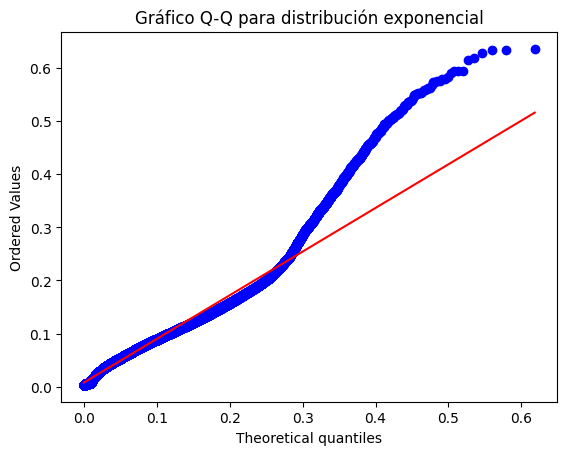

In [432]:
probplot(muestra, dist='expon', sparams=params_expon, plot=plt)
plt.title("Gráfico Q-Q para distribución exponencial")
plt.show()

In [394]:
resultado = kstest(muestra, 'expon', args=params_expon)
print(f"Valor p: {resultado.pvalue}")

Valor p: 0.0


### Weibull

In [356]:
params_weibull = weibull_min.fit(muestra, floc=0)
print(params_weibull)

(np.float64(0.7951930641917795), 0, np.float64(0.001397401903845371))


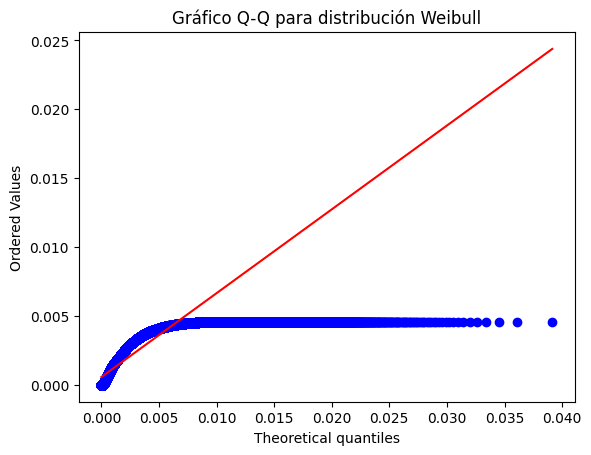

In [357]:
probplot(muestra, dist='weibull_min', sparams=params_weibull, plot=plt)
plt.title("Gráfico Q-Q para distribución Weibull")
plt.show()

### Gamma

In [325]:
params_gamma = gamma.fit(muestra, floc=0)
print(params_gamma)

(0.46937750197570693, 0, np.float64(0.006885442726804437))


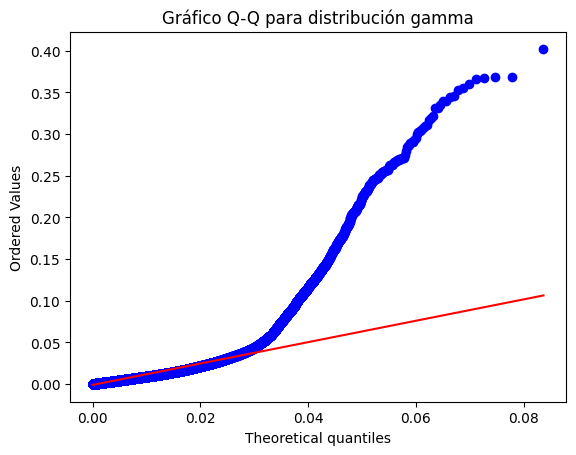

In [358]:
probplot(muestra, dist='gamma', sparams=params_gamma, plot=plt)
plt.title("Gráfico Q-Q para distribución gamma")
plt.show()

In [292]:
resultado = kstest(muestra, 'gamma', args=params_gamma)
print(f"Valor p: {resultado.pvalue}")

Valor p: 0.0


### Lognorm

In [329]:
params_lognorm = lognorm.fit(muestra, floc=0)
print(params_lognorm)

(np.float64(2.065714393657877), 0, np.float64(0.0008239846631764641))


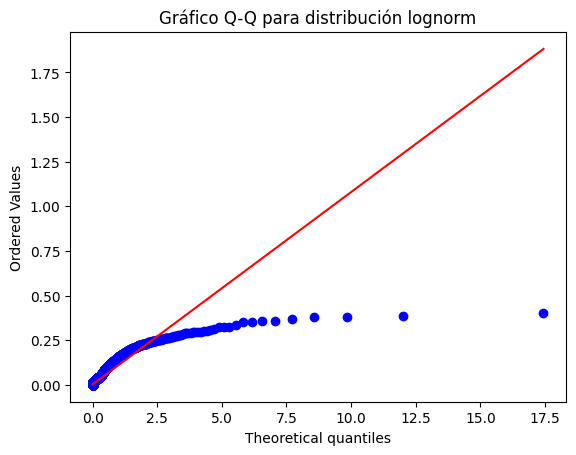

In [330]:
probplot(muestra, dist='lognorm', sparams=params_lognorm, plot=plt)
plt.title("Gráfico Q-Q para distribución lognorm")
plt.show()

In [282]:
resultado = kstest(muestra, 'pareto', args=params)
print(f"Valor p: {resultado.pvalue}")

Valor p: 0.0


### Pareto

In [331]:
params_pareto = lognorm.fit(muestra, floc=0)
print(params_pareto)

(np.float64(2.065714393657877), 0, np.float64(0.0008239846631764641))


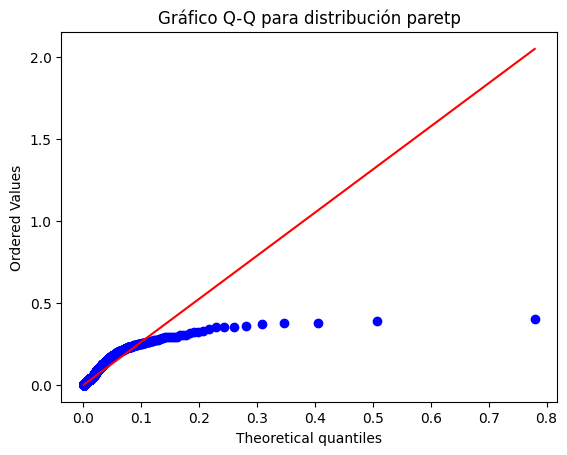

In [332]:
probplot(muestra, dist='pareto', sparams=params_pareto, plot=plt)
plt.title("Gráfico Q-Q para distribución paretp")
plt.show()

### Transformations and distributions

In [438]:
dfit = distfit()
dfit.fit_transform(muestra)


[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.01 sec] [RSS: 8.71007e+06] [loc=0.003 scale=0.007]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 6.71723e+06] [loc=0.000 scale=0.003]
[distfit] >INFO> [pareto    ] [1.30 sec] [RSS: 5.05259e+06] [loc=-0.001 scale=0.001]
[distfit] >INFO> [dweibull  ] [62.2 sec] [RSS: 2.69503e+06] [loc=0.000 scale=0.002]
[distfit] >INFO> [t         ] [150. sec] [RSS: 7.57967e+06] [loc=0.001 scale=0.001]
[distfit] >INFO> [genextreme] [96.8 sec] [RSS: 2.63885e+06] [loc=0.000 scale=0.001]
[distfit] >INFO> [gamma     ] [31.6 sec] [RSS: 6.19542e+06] [loc=0.000 scale=1.262]
[distfit] >INFO> [lognorm   ] [4.19 sec] [RSS: 2.36499e+06] [loc=0.000 scale=0.000]
[distfit] >INFO> [beta      ] [72.3 sec] [RSS: 3.88041e+06] [loc=0.000 scale=0.760]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 9.67418e+06] [loc=0.000 scale=0.404]
[distfit] >INFO> [loggamma  ] [24.9 sec] [RSS: 8.79912e+06] [loc=-1.637 scale=0.241]
[distfit] >INFO> [norm    

In [442]:
print(dfit.model)

{'name': 'lognorm', 'score': 2364991.731905962, 'loc': 1.1574074073983363e-05, 'scale': 0.00021268554982929188, 'arg': (np.float64(6.895064783706321),), 'params': (np.float64(6.895064783706321), np.float64(1.1574074073983363e-05), np.float64(0.00021268554982929188)), 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C65668F460>, 'bootstrap_score': 0, 'bootstrap_pass': None, 'color': '#e41a1c', 'CII_min_alpha': np.float64(1.157659896460714e-05), 'CII_max_alpha': np.float64(17.915695794296337)}


[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Lognorm(loc:0.000012, scale:0.000213)


(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nlognorm(s=6.89506, loc=1.15741e-05, scale=0.000212686)'}, xlabel='Values', ylabel='Frequency'>)

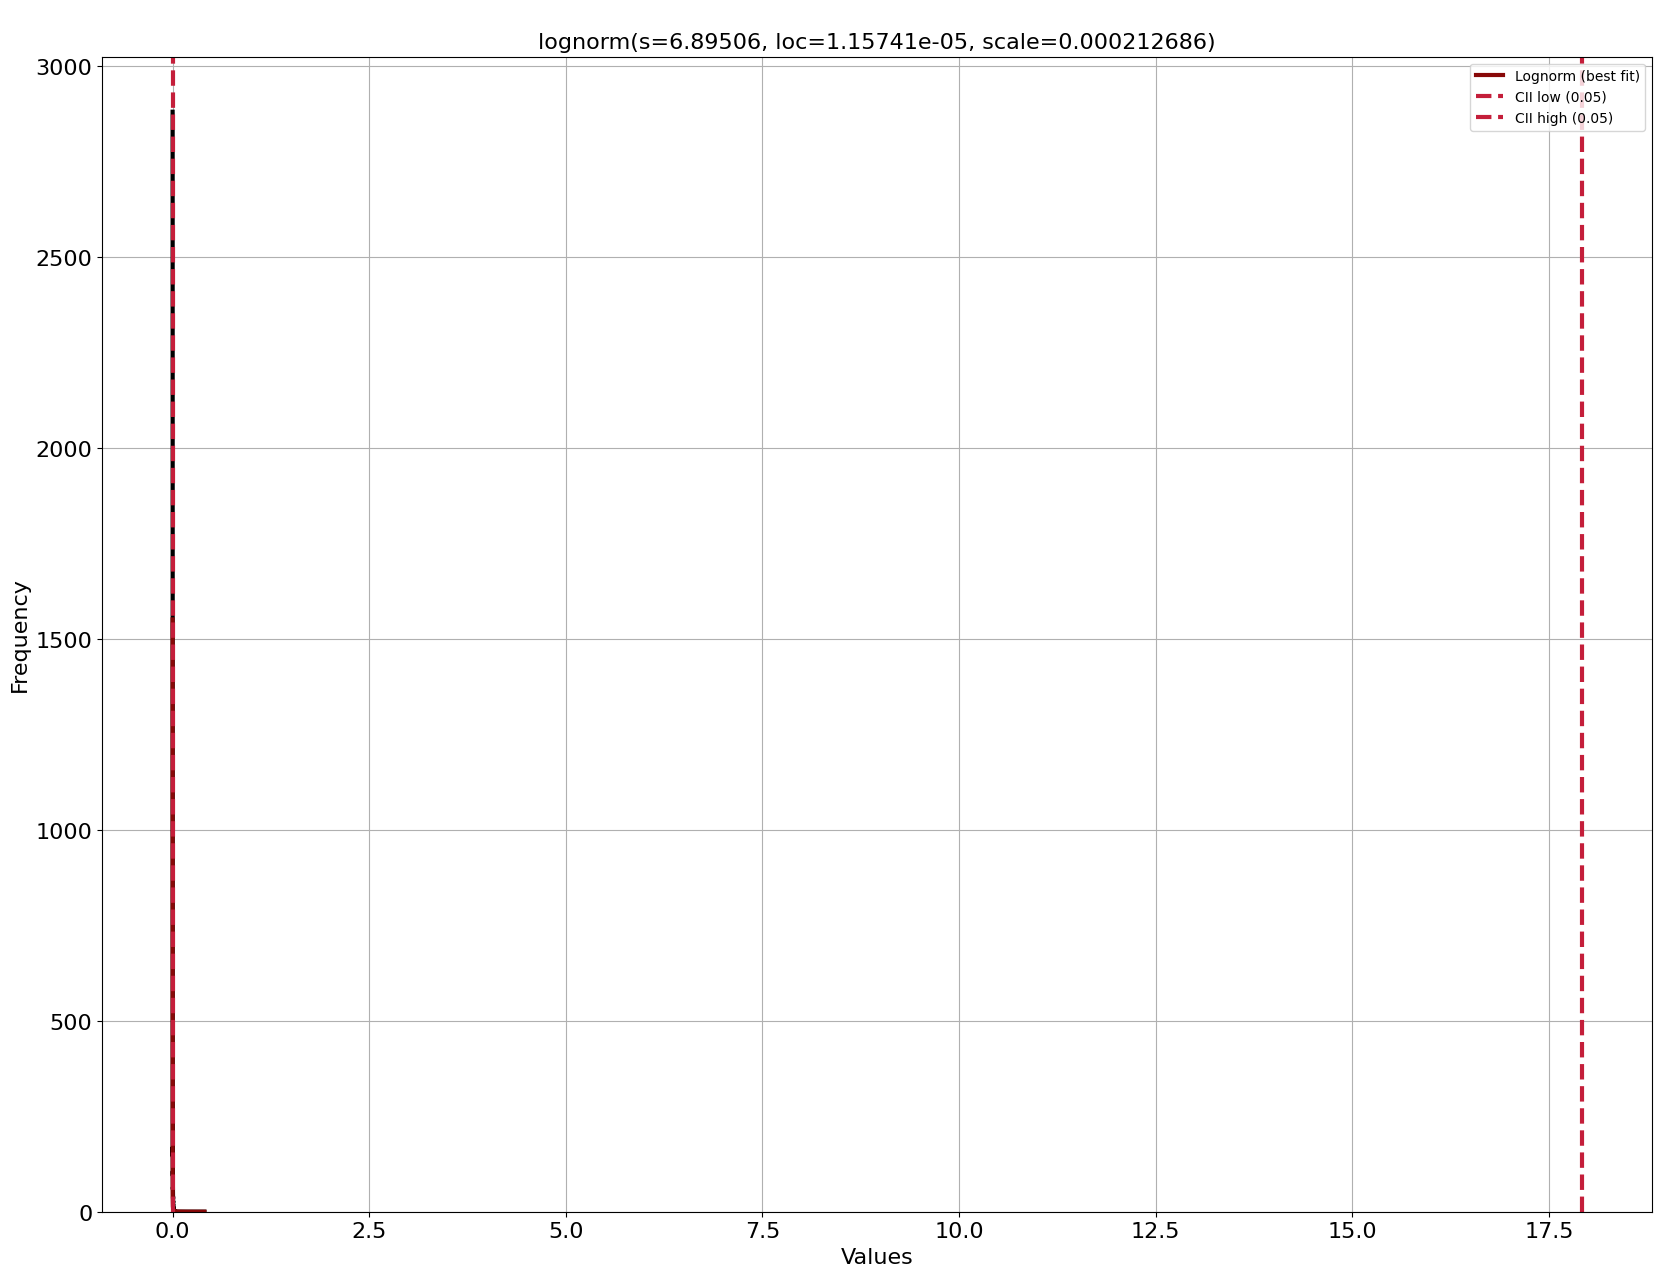

In [436]:
dfit.plot()

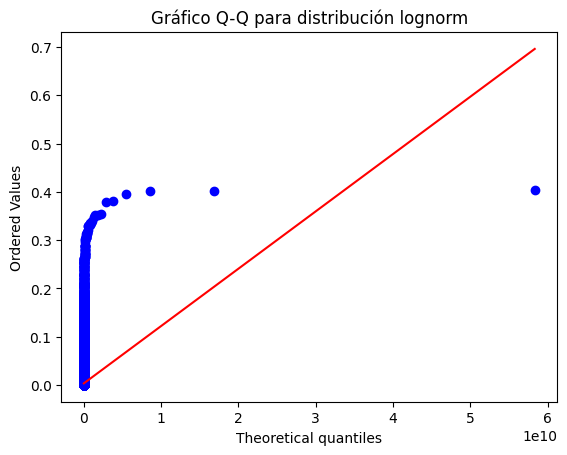

In [445]:
probplot(muestra, dist='lognorm', sparams=dfit.model['params'], plot=plt)
plt.title("Gráfico Q-Q para distribución lognorm")
plt.show()

Comentario: no se encontro una distribución que se ajuste correctamente a los datos.

Intentemos aproximar la distribución por medio de normales